## Machine Learning - FACE RECOGNITION

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

## The AT&T faces database

http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

This dataset consists of 400 grayscale faces images (112x92 pixels each) of 40 different people (10 images of each person). 

- **The aim of this project is to learn a classifier to identify each of the 40 people in the database.**

Note, that the number of features here (d=112x92=10,304) is *much higher* than the number of examples (n=400). 
In order to avoid significant overfitting of the model, we will try to reduce the number of features (using PCA) before we fit the classifier. 

### First, lets explore the database a little:
1. load the database
2. plot one image of each person (40 total) 
3. choose one person, and plot all of its images (10 total)
4. plot the *average face* by averaging over all 400 images


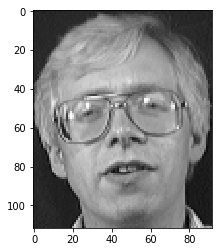

In [2]:

data = loadmat('faces112x92.mat')

faces = data['faces']
target = data['target']

ny,nx = 112,92

plt.imshow(faces[1,:].reshape(ny,nx),interpolation='nearest',cmap='gray')
plt.show()



One image of each person:


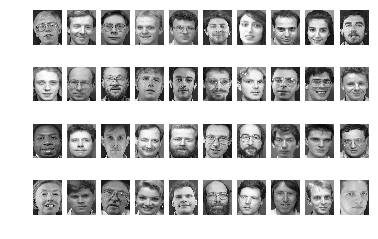

All images of one person:


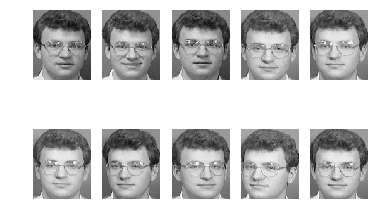

Average face:


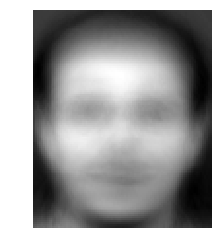

In [3]:
print("One image of each person:")
for i in range(40):  
    plt.subplot(4,10,i+1)
    plt.imshow(faces[i+1,:].reshape(ny,nx),interpolation='nearest',cmap='gray')
    plt.axis('off')
plt.show()

print("All images of one person:")
for i in range(10):  
    plt.subplot(2,5,i+1)
    plt.imshow(faces[5+40*i,:].reshape(ny,nx),interpolation='nearest',cmap='gray')
    plt.axis('off')
plt.show()

print("Average face:")
avg_faces = np.zeros((1,faces.shape[1]))

for i in range(1, faces.shape[0]):   
    avg_faces = faces[i,:] + avg_faces

avg_faces = avg_faces / faces.shape[0] 

plt.imshow(avg_faces.reshape(ny,nx),interpolation='nearest',cmap='gray')
plt.axis('off')
plt.show()


### Feature extraction using PCA

Use your own implementation of PCA to calculate the principal components of the faces.

1. Plot the values of all 400 eigenvalues
2. Plot the first 10 eigenvectors: display each eigenvector as a 112x92 grayscale image.
3. Project the data to 2-D (use the first 2 principal components) and scatter plot all the data (400 total; each person in different color).
4. Reconstruct the first image in the database using the first K principal components. Show the result for K=5,10,20,50,100.


Plot of all 400 eigenvalues:


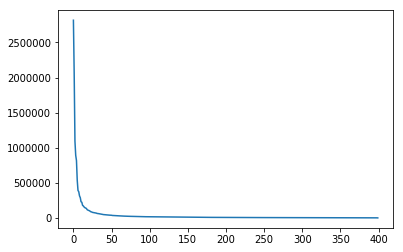

First 10 eigenvectors:


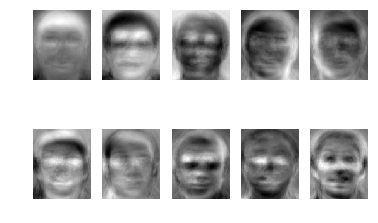

Data in 2-D, each person in different color:


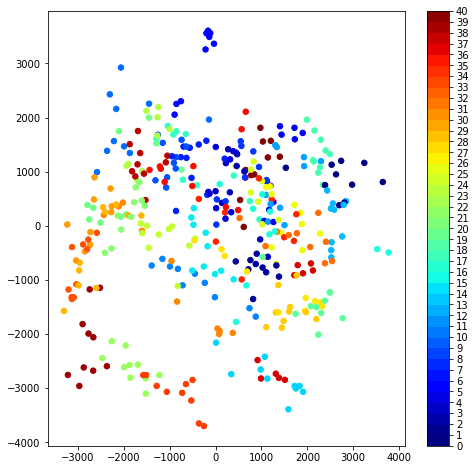

Reconstruct of the first image:


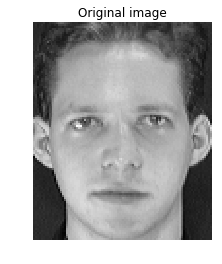

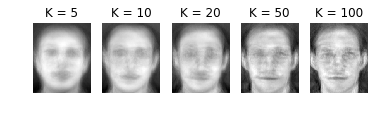

In [5]:
def PCA(X,k):
    n, d = X.shape   
    
    # normallize the data
    mu = (np.sum(X, axis = 0)) / n
    X = X - mu

    # calculate C_gal, U_gal, evls_gal
    C_gal = np.dot(X, X.T)
    C_gal = C_gal / n
        
    evls_gal, U_gal = np.linalg.eig(C_gal)
  
    idx = evls_gal.argsort()[-k:][::-1]   
    evls_gal = evls_gal[idx]
    U_gal = U_gal[:,idx]

    # calculate evls
    evls = evls_gal
    
    # calculate U
    U_tmp = np.zeros((k, d))
    
    for i in range(k):
        U_tmp[i] = np.dot(X.T, U_gal.T[i])
      
    U = U_tmp.T

    # normallize U
    U = U / np.linalg.norm(U, axis =0)

    # build Z matrix
    Z = np.zeros((n,k))
    
    for i in range(n):       
        curr_z = np.zeros(k) # curr_z = z1, z2, z3...
        
        for j in range(k):
            curr_z[j] = np.dot(X[i], U.T[j])
    
        Z[i] = curr_z

    return Z, U, evls

# Ex1
Z, U, evls = PCA(faces, 400)

print("Plot of all 400 eigenvalues:")
plt.plot(evls)
plt.show()

# Ex2
print("First 10 eigenvectors:")

ny,nx = 112,92

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(U.T[i,:].reshape(ny,nx),interpolation='nearest',cmap='gray')
    plt.axis('off')
plt.show()

# Ex3
print("Data in 2-D, each person in different color:")
y = target.reshape(400)

plt.figure(figsize=(8,8))
scat = plt.scatter(Z[:,0], Z[:,1], 30, y, cmap=plt.cm.jet)
bounds = np.linspace(0,max(y),max(y)+1)
plt.colorbar(scat, spacing='proportional',ticks=bounds, boundaries=bounds)

plt.show()

# Ex4
print("Reconstruct of the first image:")
reconstruct_index = 0

plt.imshow(faces[reconstruct_index,:].reshape(ny,nx),interpolation='nearest',cmap='gray')
plt.axis('off')
plt.title("Original image")
plt.show()

K = [5,10,20,50,100]
for i in range(len(K)):
    k = K[i]
       
    x_hat = np.zeros(faces.shape[1])

    for j in range(k):
        x_hat = x_hat + (Z[reconstruct_index][j] * U.T[j])

    x_hat = x_hat + avg_faces

    plt.subplot(1,len(K),i+1)   
    plt.title("K = %i" %k)
    plt.imshow(x_hat.reshape(ny,nx),interpolation='nearest',cmap='gray')
    plt.axis('off')
    
plt.show()

### Classification

Finally, fit a classifier to the data (after the PCA phase): either logistic-regression or SVM. Use *one-vs-all* to  classify multi-labels, just as you did in the MNIST database exercise).

We define the *accuracy score* as the percentage of faces correctly classified by the algorithm.

Try different values for each parameter you use. Use cross-validation to pick the best ones. 

Describe in graphs, scores and words all your findings.




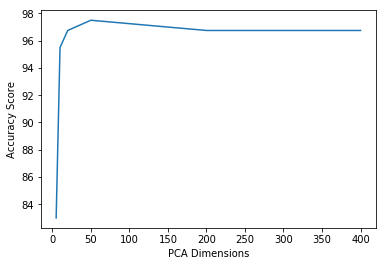

Best accuracy score is obtained with 50 PCA dimensions


In [103]:
from sklearn.svm import SVC

def classifie(pca_dim):
    # loading original data
    data = loadmat('faces112x92.mat')
    faces = data['faces']
    y = data['target'].reshape(400)
    
    # run pca
    Z, U, evls = PCA(faces, pca_dim)

    # make 4 groups from the pca data for cross-validation
    x1 = Z[:100]
    y1 = y[:100]
    
    x2 = Z[100:200]
    y2 = y[100:200]
        
    x3 = Z[200:300]
    y3 = y[200:300]    
    
    x4 = Z[300:]
    y4 = y[300:]
           
    x_arr = []
    y_arr = []
    
    x_arr.append(x1)
    x_arr.append(x2)
    x_arr.append(x3)
    x_arr.append(x4)
    
    y_arr.append(y1)
    y_arr.append(y2)
    y_arr.append(y3)
    y_arr.append(y4)
    
    # run svm on cross-validation data
    clf = SVC(C = 1000, kernel="rbf", gamma = 0.0000001)
    match_arr = []
    
    for i in range(4):
        if (i == 0):
            x_tst = x_arr[0]
            x_trn = x_arr[1]
            x_trn = np.concatenate((x_trn, x_arr[2]))
            x_trn = np.concatenate((x_trn, x_arr[3]))
            
            y_tst = y_arr[0]
            y_trn = y_arr[1]
            y_trn = np.concatenate((y_trn, y_arr[2]))
            y_trn = np.concatenate((y_trn, y_arr[3]))
        elif (i == 1):
            x_tst = x_arr[1]
            x_trn = x_arr[0]
            x_trn = np.concatenate((x_trn, x_arr[2]))
            x_trn = np.concatenate((x_trn, x_arr[3])) 
            
            y_tst = y_arr[1]
            y_trn = y_arr[0]
            y_trn = np.concatenate((y_trn, y_arr[2]))
            y_trn = np.concatenate((y_trn, y_arr[3]))  
        elif (i == 2):
            x_tst = x_arr[2]
            x_trn = x_arr[0]
            x_trn = np.concatenate((x_trn, x_arr[1]))
            x_trn = np.concatenate((x_trn, x_arr[3]))
            
            y_tst = y_arr[2]
            y_trn = y_arr[0]
            y_trn = np.concatenate((y_trn, y_arr[1]))
            y_trn = np.concatenate((y_trn, y_arr[3]))
        elif (i == 3):
            x_tst = x_arr[3]
            x_trn = x_arr[0]
            x_trn = np.concatenate((x_trn, x_arr[1]))
            x_trn = np.concatenate((x_trn, x_arr[2]))
            
            y_tst = y_arr[3]
            y_trn = y_arr[0]
            y_trn = np.concatenate((y_trn, y_arr[1]))
            y_trn = np.concatenate((y_trn, y_arr[2]))

        clf.fit(x_trn, y_trn)
        yhat = clf.predict(x_tst)

        yhat_y_match = np.zeros(y_tst.shape[0])
        yhat_y_match[y_tst==yhat] = 1

        match_arr.append((np.sum(yhat_y_match) / y_tst.shape[0]) * 100)
    
    accuracy_score = np.sum(match_arr) / 4
  
    return accuracy_score

K = [5,10,20,50,100,200,400]
acc_score_arr = []

for i in range(len(K)):
    k = K[i]      
    acurracy_score = classifie(k)
    acc_score_arr.append(acurracy_score)
    
plt.plot(K, acc_score_arr)
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy Score')
plt.show()

print("Best accuracy score is obtained with", K[acc_score_arr.index(max(acc_score_arr))], "PCA dimensions")

## Good luck!